# Imports

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import cluster
from matplotlib import gridspec
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load Data

In [2]:
df = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str, "count": int, "imtime": str},
                 parse_dates=["date"], infer_datetime_format=True, index_col="date")

print df.dtypes
df.head(2)

cam_id      int64
cam_dir    object
count       int64
imtime     object
dtype: object


,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [3]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


# Camera Average (Weekday, Weekend, and July 4th).

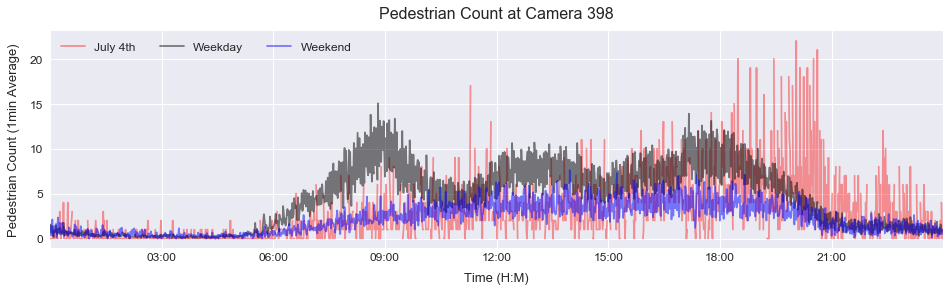

In [4]:
def groupby_min(df, dur):
    temp = df.copy()
    temp.index = map(lambda x: pd.datetime.combine(datetime.datetime.today(), x), temp.index.time)
    return temp.resample(dur).mean()

def plot_camera_avg(df, cam=None):
    if cam == None:
        weekday = groupby_min(df[(df.index.weekday < 5) & (df.index != "2017-07-04")], "1Min")
        weekend = groupby_min(df[(df.index.weekday >= 5)], "1Min")
        july4 = groupby_min(df[(df.index > "2017-07-04") & (df.index < "2017-07-05")], "1Min")
    else:
        weekday = groupby_min(df[(df.index.weekday < 5) & (df.cam_id == cam) & (df.index != "2017-07-04")], "1Min")
        weekend = groupby_min(df[(df.index.weekday >= 5) & (df.cam_id == cam)], "1Min")
        july4 = groupby_min(df[(df.index > "2017-07-04") & (df.index < "2017-07-05") & (df.cam_id == cam)], "1Min")

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    
    july4["count"].plot(ax=ax1, c="r", alpha=0.4, label="July 4th")
    weekday["count"].plot(ax=ax1, c="k", alpha=0.5, label="Weekday")
    weekend["count"].plot(ax=ax1, c="b", alpha=0.5, label="Weekend")

    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.grid(True, which="both")
    ax1.tick_params(axis="both", which="both", labelsize=12)
    ax1.legend(ncol=3, fontsize=12)
    
    return fig, ax1

cam_id = 398 # Edit camera id here.
fig, ax1 = plot_camera_avg(df, cam_id) 

ax1.set_xlabel("Time (H:M)", fontsize=13, labelpad=10)
ax1.set_ylabel("Pedestrian Count (1min Average)", fontsize=13, labelpad=10)
ax1.set_title("Pedestrian Count at Camera {}".format(cam_id), fontsize=16, y=1.03)

# Cameras Average (Manhattan)

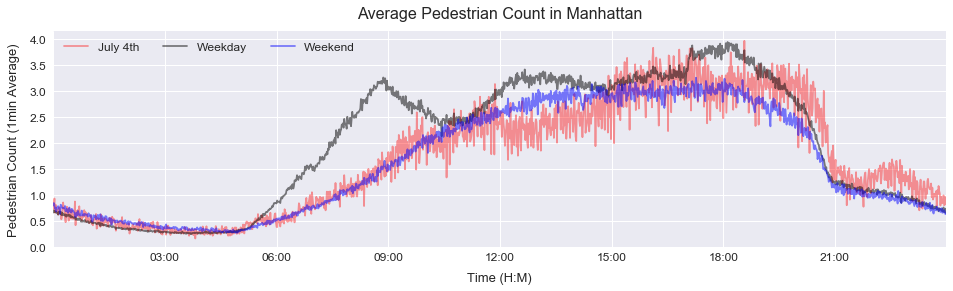

In [5]:
df_man = df[df["cam_id"].isin(cams[(cams["boro"] == "Manhattan") & (cams["people"] == 1.)].cam_id.unique())]
fig, ax1 = plot_camera_avg(df_man)
ax1.set_xlabel("Time (H:M)", fontsize=13, labelpad=10)
ax1.set_ylabel("Pedestrian Count (1min Average)", fontsize=13, labelpad=10)
ax1.set_title("Average Pedestrian Count in Manhattan", fontsize=16, y=1.03)

# Timeseries Image
## Weekday

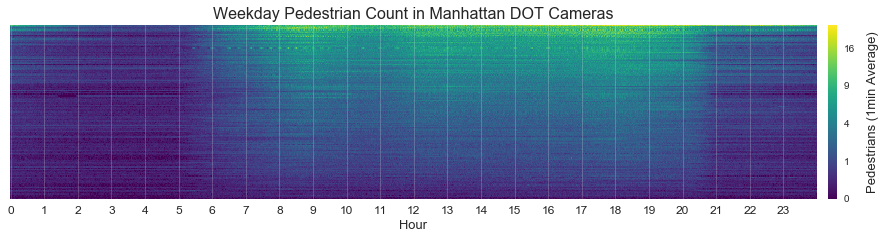

In [27]:
df_man_weekday = df_man[(df_man.index.weekday < 5)]
ts = []
for cam in df_man_weekday.groupby("cam_id").mean().sort_values("count", ascending=False).index:
    d = [np.sqrt(i) for i in groupby_min(pd.DataFrame(df_man_weekday[df_man_weekday["cam_id"] == cam]["count"]), "1Min")["count"].values]
    if len(d) == 1440:
        ts.append(d)
        ts.append(d)
ts = pd.DataFrame(ts)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
im = ax1.imshow(ts.values, cmap="viridis")
fig.tight_layout()
ax1.grid(alpha=0.2)
ax1.set_yticks([])
ax1.set_xticklabels(range(24))
ax1.set_xticks(np.arange(0, 1440, 60))
cbar = fig.colorbar(im, ax=ax1, pad=0.01)
cbar.ax.set_yticklabels([0, 1, 4, 9, 16, 25, 36])
ax1.set_title("Weekday Pedestrian Count in Manhattan DOT Cameras", fontsize=16)
ax1.set_xlabel("Hour", fontsize=13)
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_ylabel("Pedestrians (1min Average)", fontsize=13, labelpad=50)

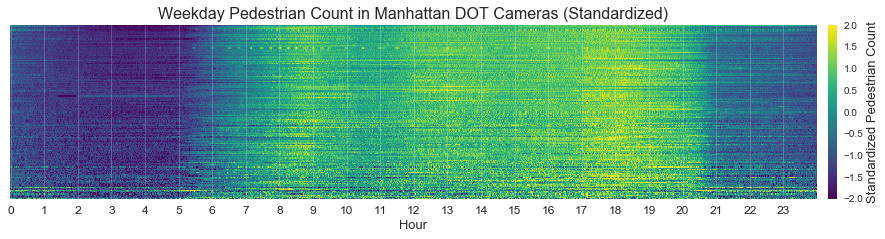

In [28]:
ts = ts.T
ts = (ts - ts.mean()) / ts.std()

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
im = ax1.imshow(ts.T.values, cmap="viridis")
im.set_clim(-2, 2)
fig.tight_layout()
ax1.grid(alpha=0.2)
ax1.set_yticks([])
ax1.set_xticklabels(range(24))
ax1.set_xticks(np.arange(0, 1440, 60))
cbar = fig.colorbar(im, ax=ax1, pad=0.01)
ax1.set_title("Weekday Pedestrian Count in Manhattan DOT Cameras (Standardized)", fontsize=16)
ax1.set_xlabel("Hour", fontsize=13)
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_ylabel("Standardized Pedestrian Count", fontsize=13, labelpad=50)

## Weekend

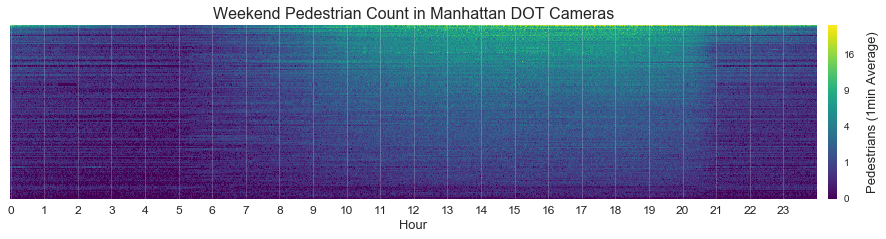

In [8]:
df_man_weekend = df_man[df_man.index.weekday >= 5]
ts = []
for cam in df_man_weekend.groupby("cam_id").mean().sort_values("count", ascending=False).index:
    d = [np.sqrt(i) for i in groupby_min(pd.DataFrame(df_man_weekend[df_man_weekend["cam_id"] == cam]["count"]), "1Min")["count"].values]
    if len(d) == 1440:
        ts.append(d)
        ts.append(d)
ts = pd.DataFrame(ts)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
im = ax1.imshow(ts.values, cmap="viridis")
fig.tight_layout()
ax1.grid(alpha=0.2)
ax1.set_yticks([])
ax1.set_xticklabels(range(24))
ax1.set_xticks(np.arange(0, 1440, 60))
cbar = fig.colorbar(im, ax=ax1, pad=0.01)
cbar.ax.set_yticklabels([0, 1, 4, 9, 16, 25, 36])
ax1.set_title("Weekend Pedestrian Count in Manhattan DOT Cameras", fontsize=16)
ax1.set_xlabel("Hour", fontsize=13)
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_ylabel("Pedestrians (1min Average)", fontsize=13, labelpad=50)

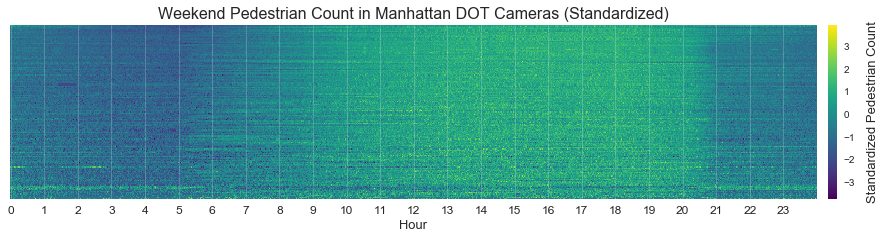

In [9]:
ts = ts.T
ts = (ts - ts.mean()) / ts.std()

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
im = ax1.imshow(ts.T.values, cmap="viridis")
fig.tight_layout()
ax1.grid(alpha=0.2)
ax1.set_yticks([])
ax1.set_xticklabels(range(24))
ax1.set_xticks(np.arange(0, 1440, 60))
cbar = fig.colorbar(im, ax=ax1, pad=0.01)
ax1.set_title("Weekend Pedestrian Count in Manhattan DOT Cameras (Standardized)", fontsize=16)
ax1.set_xlabel("Hour", fontsize=13)
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_ylabel("Standardized Pedestrian Count", fontsize=13, labelpad=50)

# Clustering
### Prep spatial data.

In [10]:
nyc = gpd.read_file("../data/external/nyc_shp/nybb.shp")
nyc = nyc.to_crs({'init': 'epsg:4326'})

geometry = [Point(xy) for xy in zip(cams["long"], cams["lat"])]
cams.drop(["long", "lat"],  axis=1, inplace=True)
cams = gpd.GeoDataFrame(cams, crs={'init': 'epsg:4326'}, geometry=geometry)
cams.head(2)

,cam_id,cctv_id,description,people,ribbon,boro,zipcode,geometry
0,112,83,SIE @ Richmond Ave,0.0,1.0,Staten Island,10314,POINT (-74.15743499999999 40.614885)
1,121,129,LIE @ Kissena Blvd,1.0,0.0,Queens,11367,POINT (-73.81504699999999 40.738943)


In [11]:
weekday_temp = []
for cam in df_man_weekday["cam_id"].unique():
    t = groupby_min(df_man_weekday[df_man_weekday["cam_id"] == cam], "1Min")
    t.columns = ["cam_id", str(cam)]
    weekday_temp.append(t[str(cam)])

weekend_temp = []
for cam in df_man_weekend["cam_id"].unique():
    t = groupby_min(df_man_weekend[df_man_weekend["cam_id"] == cam], "1Min")
    t.columns = ["cam_id", str(cam)]
    weekend_temp.append(t[str(cam)])

In [12]:
weekday_df = pd.concat(weekday_temp, axis=1)
weekday_df = (weekday_df - weekday_df.min()) / (weekday_df.max() - weekday_df.min())
weekday_df = weekday_df.T
weekday_df.columns = pd.MultiIndex.from_tuples(map(lambda x: ("Weekday", x), weekday_df.columns))

weekend_df = pd.concat(weekend_temp, axis=1)
weekend_df = (weekend_df - weekend_df.min()) / (weekend_df.max() - weekend_df.min())
weekend_df = weekend_df.T
weekend_df.columns = pd.MultiIndex.from_tuples(map(lambda x: ("Weekend", x), weekend_df.columns))

df_clust = weekday_df.merge(weekend_df, left_index=True, right_index=True)
df_clust.index = pd.to_numeric(df_clust.index)
df_clust.head()

Weekday                                          \
    2017-08-30 00:00:00 2017-08-30 00:01:00 2017-08-30 00:02:00   
545            0.201271            0.150071            0.174558   
544            0.215783            0.192663            0.201710   
247            0.083008            0.146249            0.141659   
794            0.050179            0.133482            0.100982   
165            0.089315            0.136623            0.148450   

                                                                 \
    2017-08-30 00:03:00 2017-08-30 00:04:00 2017-08-30 00:05:00   
545            0.189456            0.189893            0.170551   
544            0.160652            0.231196            0.178792   
247            0.144209            0.108116            0.037987   
794            0.050179            0.071685            0.083871   
165            0.129800            0.050195            0.101958   

                                                                 \
    2017-08-30 00:06:00 2017-08-30 00:07:00 2017-08-30 00:08:00   
545            0.118563            0.177640            0.236718   
544            0.192663            0.160652            0.176657   
247            0.094967            0.118708            0.179297   
794            0.081886            0.133995            0.089330   
165            0.152936            0.168655            0.045456   

                                ...                     Weekend  \
    2017-08-30 00:09:00         ...         2017-08-30 23:50:00   
545            0.157385         ...                    0.189723   
544            0.192663         ...                    0.159091   
247            0.138380         ...                    0.272222   
794            0.041475         ...                    0.047847   
165            0.146479         ...                    0.166667   

                                                                 \
    2017-08-30 23:51:00 2017-08-30 23:52:00 2017-08-30 23:53:00   
545            0.208696            0.166008            0.358696   
544            0.070000            0.175000            0.272222   
247            0.207407            0.186667            0.155556   
794            0.131579            0.078947            0.146199   
165            0.296296            0.266667            0.333333   

                                                                 \
    2017-08-30 23:54:00 2017-08-30 23:55:00 2017-08-30 23:56:00   
545            0.202899            0.231884            0.118577   
544            0.077778            0.194444            0.127273   
247            0.051852            0.233333            0.233333   
794            0.058480            0.087719            0.095694   
165            0.259259            0.233333            0.233333   

                                                                 
    2017-08-30 23:57:00 2017-08-30 23:58:00 2017-08-30 23:59:00  
545            0.260870            0.231884            0.182609  
544            0.140000            0.233333            0.210000  
247            0.042424            0.058333            0.140000  
794            0.052632            0.175439            0.131579  
165            0.151515            0.166667            0.151515  

[5 rows x 2880 columns]

### Kmeans

In [13]:
for n_clusters in range(2, 12):
    clust = cluster.KMeans(n_clusters=n_clusters)
    clust_labels = clust.fit_predict(df_clust)
    print "For {} clusters, the average silhouette score is: {}".format(n_clusters, silhouette_score(df_clust, clust_labels))

For 2 clusters, the average silhouette score is: 0.162578156633
For 3 clusters, the average silhouette score is: 0.108927611277
For 4 clusters, the average silhouette score is: 0.0566608420677
For 5 clusters, the average silhouette score is: 0.0509016851024
For 6 clusters, the average silhouette score is: 0.0466145942161
For 7 clusters, the average silhouette score is: 0.0420247097408
For 8 clusters, the average silhouette score is: 0.0637804489383
For 9 clusters, the average silhouette score is: 0.0363336990725
For 10 clusters, the average silhouette score is: 0.0343851158605
For 11 clusters, the average silhouette score is: 0.0324274345505


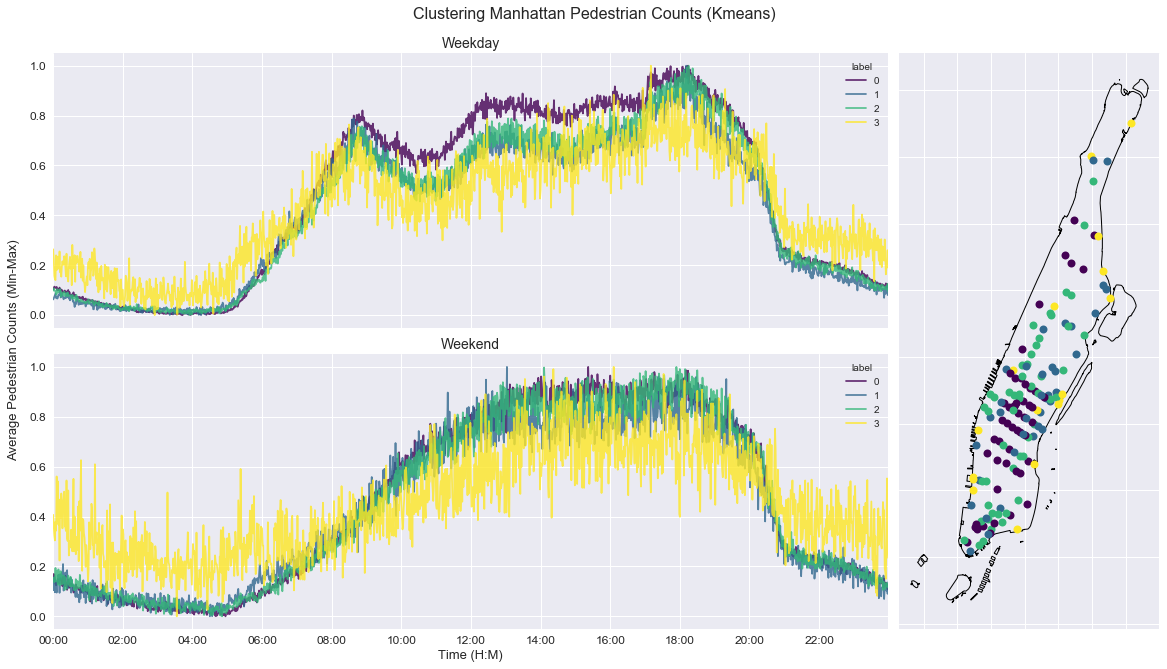

In [17]:
clust = cluster.KMeans(n_clusters=4).fit(df_clust)
labels = pd.DataFrame(zip(df_clust.index, clust.labels_), columns=["cam_id", "label"])
labels.cam_id = pd.to_numeric(labels.cam_id)
cams_clust = cams.merge(labels, on="cam_id", how="right")

fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1.25])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[:, 1])
ax3 = plt.subplot(gs[2])

df_clust_weekday = df_clust[["Weekday"]]
df_clust_weekday.columns = df_clust_weekday.columns.droplevel()
df_clust_weekday = df_clust_weekday.merge(labels.set_index("cam_id"), how="right", left_index=True, right_index=True)
df_clust_weekday = df_clust_weekday.groupby("label").mean().T
df_clust_weekday = (df_clust_weekday - df_clust_weekday.min()) / (df_clust_weekday.max() - df_clust_weekday.min())
df_clust_weekday.plot(ax=ax1, cmap="viridis", alpha=0.8)

df_clust_weekend = df_clust[["Weekend"]]
df_clust_weekend.columns = df_clust_weekend.columns.droplevel()
df_clust_weekend = df_clust_weekend.merge(labels.set_index("cam_id"), how="right", left_index=True, right_index=True)
df_clust_weekend = df_clust_weekend.groupby("label").mean().T
df_clust_weekend = (df_clust_weekend - df_clust_weekend.min()) / (df_clust_weekend.max() - df_clust_weekend.min())
df_clust_weekend.plot(ax=ax3, cmap="viridis", alpha=0.8)

nyc[nyc["BoroName"] == "Manhattan"].plot(ax=ax2, facecolor="none")
cams_clust.plot(ax=ax2, column="label", cmap="viridis", markersize=8)

fig.text(-0.01, 0.5, "Average Pedestrian Counts (Min-Max)", va="center", rotation="vertical", fontsize=13)
ax1.set_xticklabels([])
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_title("Weekday", fontsize=14)
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_title("Weekend", fontsize=14)
ax3.set_xlabel("Time (H:M)", fontsize=13)
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax3.tick_params(axis="both", which="both", labelsize=12)
fig.suptitle("Clustering Manhattan Pedestrian Counts (Kmeans)", fontsize=16, y=1.03)
fig.autofmt_xdate(rotation=0, ha="center")
plt.tight_layout()

### Agglomerative Clustering

In [18]:
for n_clusters in range(2, 12):
    clust = cluster.AgglomerativeClustering(n_clusters=n_clusters)
    clust_labels = clust.fit_predict(df_clust)
    print "For {} clusters, the average silhouette score is: {}".format(n_clusters, silhouette_score(df_clust, clust_labels))

For 2 clusters, the average silhouette score is: 0.169669665852
For 3 clusters, the average silhouette score is: 0.104927588211
For 4 clusters, the average silhouette score is: 0.0618761758012
For 5 clusters, the average silhouette score is: 0.0670821124367
For 6 clusters, the average silhouette score is: 0.0330105870159
For 7 clusters, the average silhouette score is: 0.0349602888299
For 8 clusters, the average silhouette score is: 0.0250961510273
For 9 clusters, the average silhouette score is: 0.0270634019052
For 10 clusters, the average silhouette score is: 0.0237470426656
For 11 clusters, the average silhouette score is: 0.0250163554917


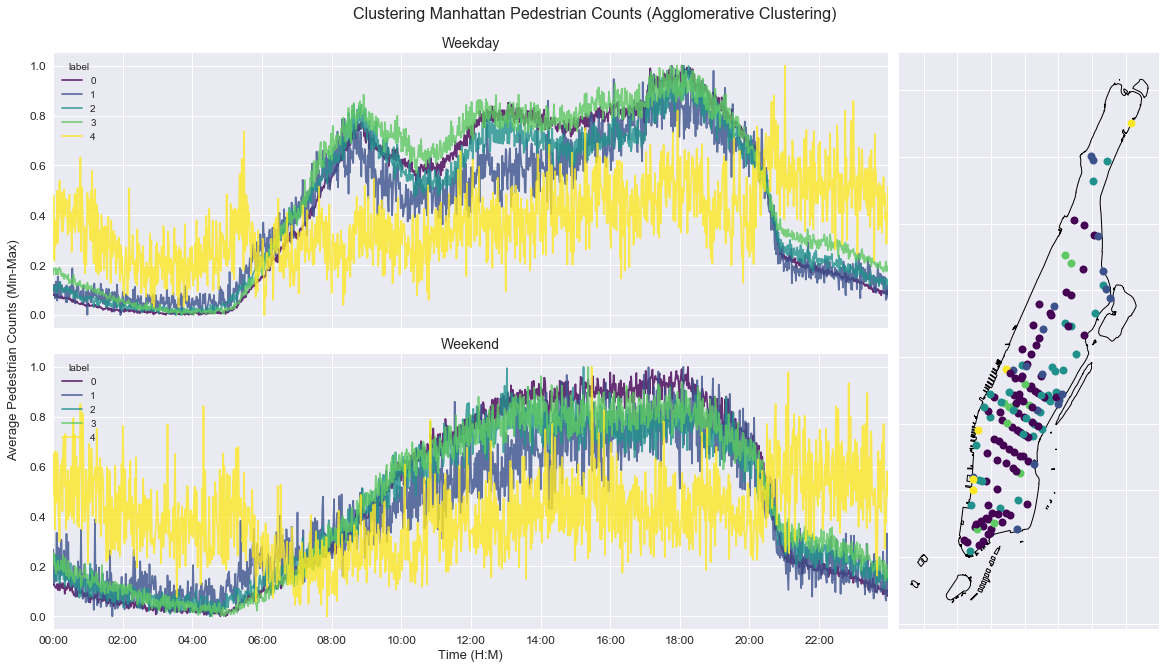

In [19]:
clust = cluster.AgglomerativeClustering(n_clusters=5).fit(df_clust)
labels = pd.DataFrame(zip(df_clust.index, clust.labels_), columns=["cam_id", "label"])
labels.cam_id = pd.to_numeric(labels.cam_id)
cams_clust = cams.merge(labels, on="cam_id", how="right")

fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1.25])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[:, 1])
ax3 = plt.subplot(gs[2])

df_clust_weekday = df_clust[["Weekday"]]
df_clust_weekday.columns = df_clust_weekday.columns.droplevel()
df_clust_weekday = df_clust_weekday.merge(labels.set_index("cam_id"), how="right", left_index=True, right_index=True)
df_clust_weekday = df_clust_weekday.groupby("label").mean().T
df_clust_weekday = (df_clust_weekday - df_clust_weekday.min()) / (df_clust_weekday.max() - df_clust_weekday.min())
df_clust_weekday.plot(ax=ax1, cmap="viridis", alpha=0.8)

df_clust_weekend = df_clust[["Weekend"]]
df_clust_weekend.columns = df_clust_weekend.columns.droplevel()
df_clust_weekend = df_clust_weekend.merge(labels.set_index("cam_id"), how="right", left_index=True, right_index=True)
df_clust_weekend = df_clust_weekend.groupby("label").mean().T
df_clust_weekend = (df_clust_weekend - df_clust_weekend.min()) / (df_clust_weekend.max() - df_clust_weekend.min())
df_clust_weekend.plot(ax=ax3, cmap="viridis", alpha=0.8)

nyc[nyc["BoroName"] == "Manhattan"].plot(ax=ax2, facecolor="none")
cams_clust.plot(ax=ax2, column="label", cmap="viridis", markersize=8)

fig.text(-0.01, 0.5, "Average Pedestrian Counts (Min-Max)", va="center", rotation="vertical", fontsize=13)
ax1.set_xticklabels([])
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_title("Weekday", fontsize=14)
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_title("Weekend", fontsize=14)
ax3.set_xlabel("Time (H:M)", fontsize=13)
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax3.tick_params(axis="both", which="both", labelsize=12)
fig.suptitle("Clustering Manhattan Pedestrian Counts (Agglomerative Clustering)", fontsize=16, y=1.03)
fig.autofmt_xdate(rotation=0, ha="center")
plt.tight_layout()